In [35]:
import pandas as pd
import numpy as np
import scipy.stats
from statsmodels.sandbox.stats.multicomp import multipletests 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def write_ans(ans,name):
    with open(name,'w') as file1:
        file1.write(str(ans))

In [3]:
data = pd.read_csv('ab_browser_test.csv', sep=',')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [4]:
control = data[data['slot'] == 'control']
expr = data[data['slot'] == 'exp']
ans1 = (float(expr.n_clicks.sum())/float(control.n_clicks.sum()) - 1) * 100
print(ans1)
write_ans(ans1,'ans1.txt')

1.61356898244


In [5]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [6]:
n_boot_samples = 500
exp_median_scores = map(np.median, get_bootstrap_samples(expr.n_clicks.values.astype(float), n_boot_samples))
control_median_scores = map(np.median, get_bootstrap_samples(control.n_clicks.values.astype(float), n_boot_samples))

print "95% confidence interval for the ILEC median repair time:",  stat_intervals(exp_median_scores, 0.05)
print "95% confidence interval for the CLEC median repair time:",  stat_intervals(control_median_scores, 0.05)

95% confidence interval for the ILEC median repair time: [ 5.  5.]
95% confidence interval for the CLEC median repair time: [ 4.  4.]


In [7]:
exp_mean_scores = map(np.mean, get_bootstrap_samples(expr.n_clicks.values.astype(float), n_boot_samples))
control_mean_scores = map(np.mean, get_bootstrap_samples(control.n_clicks.values.astype(float), n_boot_samples))

print "95% confidence interval for the ILEC median repair time:",  stat_intervals(exp_mean_scores, 0.05)
print "95% confidence interval for the CLEC median repair time:",  stat_intervals(control_mean_scores, 0.05)

95% confidence interval for the ILEC median repair time: [ 11.5208265   11.66423272]
95% confidence interval for the CLEC median repair time: [ 11.20467126  11.34835225]


In [8]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(exp_median_scores, control_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [-1. -1.]


In [9]:
delta_mean_scores = map(lambda x: x[1] - x[0], zip(exp_mean_scores, control_mean_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_mean_scores, 0.05)

95% confidence interval for the difference between medians [-0.41578043 -0.21061161]


In [10]:
def sq(data):
    sq = 0
    mean = data.mean()
    for i in data:
        sq += (i - mean)**2
    return sq

In [11]:
np.random.seed(0)
n_boot_samples = 500
bt = get_bootstrap_samples(control.n_clicks.values.astype(float), n_boot_samples)
control_boot_mean_scores = map(np.mean, bt)
control_boot_chi_squared = map(sq, bt)

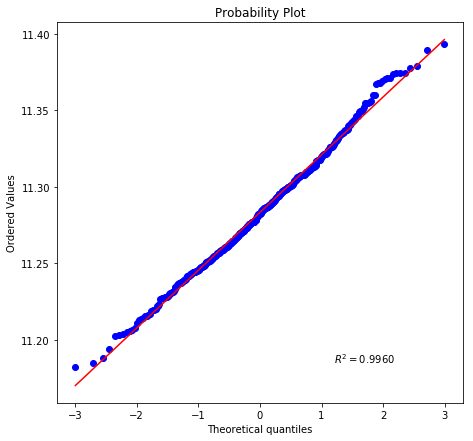

In [12]:
plt.figure(figsize(16,7))
plt.subplot(121)
scipy.stats.probplot(control_boot_mean_scores, dist="norm", plot=pylab, rvalue=True)
pylab.show()

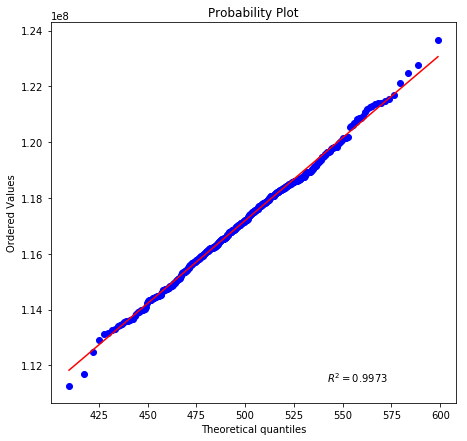

In [13]:
plt.figure(figsize(16,7))
plt.subplot(122)
scipy.stats.probplot(control_boot_chi_squared, dist="chi2", 
                     sparams=(499), plot=plt, rvalue=True)
pylab.show()

In [14]:
ucont = pd.pivot_table(control, index=['userID'], aggfunc='sum')
uexpr = pd.pivot_table(expr, index=['userID'], aggfunc='sum')

In [19]:
scipy.stats.mannwhitneyu(ucont.n_clicks,uexpr.n_clicks)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

In [38]:
p = []
for brow in control.browser.unique():
    p.append(scipy.stats.mannwhitneyu(control[control['browser'] == brow].n_clicks, expr[expr['browser'] == brow].n_clicks)[1])
reject, p_corrected, a1, a2 = multipletests(p, 
                                            alpha = 0.05/6, 
                                            method = 'holm') 
print p_corrected

[ 0.81521235  0.          0.1362193   0.81521235  0.77221655  0.14960241]


In [51]:
for brow in control.browser.unique():
    dol_control = float(control[control['browser'] == brow].n_nonclk_queries.sum()) / control[control['browser'] == brow].n_queries.sum() * 100
    dol_exp = float(expr[expr['browser'] == brow].n_nonclk_queries.sum()) / expr[expr['browser'] == brow].n_queries.sum() * 100
    print dol_control, dol_exp

46.9709296351 45.1429419036
57.5904113601 43.7556173613
45.9627471792 44.9827469486
40.5404847434 38.9773764837
40.5939765935 39.8539472197
36.2993667463 36.9374128487


In [39]:
control.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
3,6,Browser #4,control,12,6,0
5,8,Browser #4,control,4,4,1
7,10,Browser #4,control,22,15,2
9,15,Browser #14,control,2,2,0
13,23,Browser #4,control,3,1,0
